# ==========================================
# [GitHub](https://github.com/brnsmit/Deep_Fashion_Challenge)
# ==========================================

# 1. Configuração Inicial e Carregamento de Dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vit_b_16
import torch.nn as nn
import torch.optim as optim

Mounted at /content/drive


# 2. Pré-processamento de Imagens

In [4]:
# == Selecionar 5 classes com 50 imagens cada == Redução do dataset devido limitação de RAM do colab ==

import random
from collections import defaultdict

# Caminho raiz
root_dir = '/content/drive/MyDrive/DORIS/dataset/img'

# Escolhe 5 classes aleatórias que tenham pelo menos 50 imagens
valid_classes = []
for cls in os.listdir(root_dir):
    cls_path = os.path.join(root_dir, cls)
    if os.path.isdir(cls_path) and len(os.listdir(cls_path)) >= 50:
        valid_classes.append(cls)

selected_classes = random.sample(valid_classes, 5)
print("Classes selecionadas:", selected_classes)

Classes selecionadas: ['Cotton_Twill_Trench_Coat', 'Chic_95_Tee', 'Diamond_Print_Chiffon_Cardigan', 'Bandana_Print_Tee', 'Classic_Crocheted_Lace_Blouse']


In [5]:
# == Dataset customizado com 50 imagens por classe ==

class SmallFashionDataset(Dataset):
    def __init__(self, root_dir, selected_classes, transform=None, samples_per_class=50):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = {cls: i for i, cls in enumerate(selected_classes)}

        for cls in selected_classes:
            cls_path = os.path.join(root_dir, cls)
            images = os.listdir(cls_path)[:samples_per_class]
            for img in images:
                self.image_paths.append(os.path.join(cls_path, img))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = SmallFashionDataset(root_dir, selected_classes, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# 3. Modelo com ViT

In [ ]:
from torchvision.models import vit_b_16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 5

model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

100%|██████████| 13/13 [06:52<00:00, 31.71s/it]


Epoch 1, Loss: 1.1287, Accuracy: 61.00%


100%|██████████| 13/13 [06:27<00:00, 29.80s/it]


Epoch 2, Loss: 0.2302, Accuracy: 95.00%


100%|██████████| 13/13 [06:35<00:00, 30.46s/it]


Epoch 3, Loss: 0.0559, Accuracy: 99.00%


100%|██████████| 13/13 [06:24<00:00, 29.57s/it]


Epoch 4, Loss: 0.0628, Accuracy: 97.50%


100%|██████████| 13/13 [06:35<00:00, 30.41s/it]


Epoch 5, Loss: 0.0350, Accuracy: 99.50%


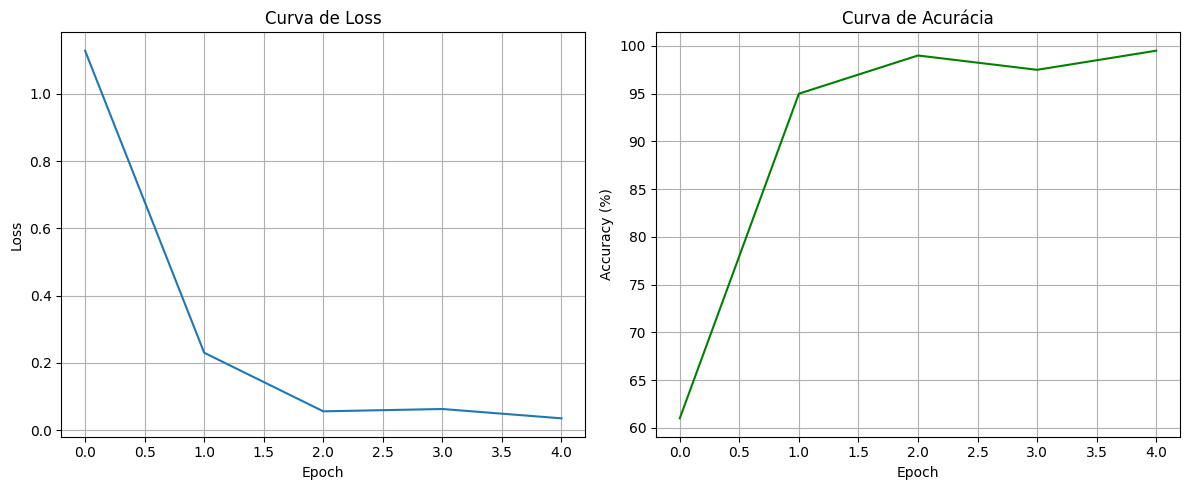

In [ ]:
# == Treinamento com curvas de loss e acurácia ==

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, loader, epochs=5):
    model.train()
    train_loss_history = []
    acc_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(loader)
        epoch_acc = 100 * correct / total
        train_loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Curvas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Curva de Loss'); plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(acc_history, label='Accuracy', color='green')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Curva de Acurácia'); plt.grid()

    plt.tight_layout()
    plt.show()

train_model(model, train_loader, epochs=5)

# 4. Avaliação + Matriz de Confusão

                                 precision    recall  f1-score   support

Diamond_Print_Halter_Cami_Dress       0.87      0.93      0.90        14
          Chic_Sweater_Crop_Top       1.00      0.78      0.88         9
            Cutout_A-Line_Dress       0.70      0.88      0.78         8
        Contrast-Paneled_Henley       0.78      0.88      0.82         8
       Dip-Dyed_Knotted_Sweater       0.89      0.73      0.80        11

                       accuracy                           0.84        50
                      macro avg       0.85      0.84      0.83        50
                   weighted avg       0.85      0.84      0.84        50



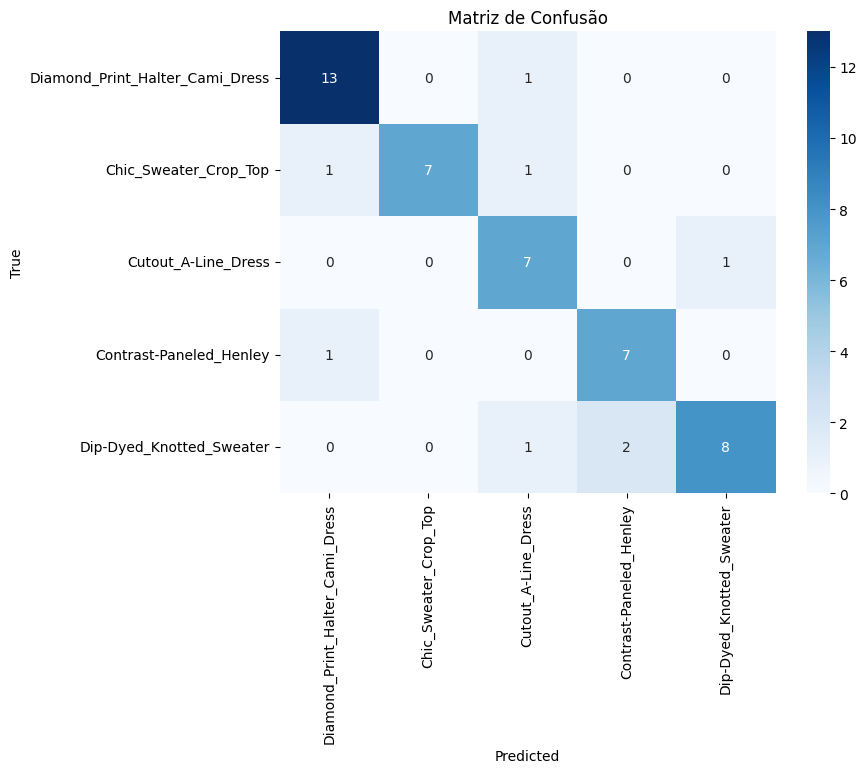

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=selected_classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=selected_classes, yticklabels=selected_classes, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Matriz de Confusão')
    plt.show()

evaluate_model(model, test_loader)